# Importing OSM data from osmnx

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [2]:
import osmnx as ox
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# centrepoint
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buffer_dist = 1250
buffer_poly = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buffer_poly.bounds

# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=buffer_dist, simplify=False)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `io.nx_from_osm_nx` method).


INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 5388/5388 [00:01<00:00, 2761.49it/s]


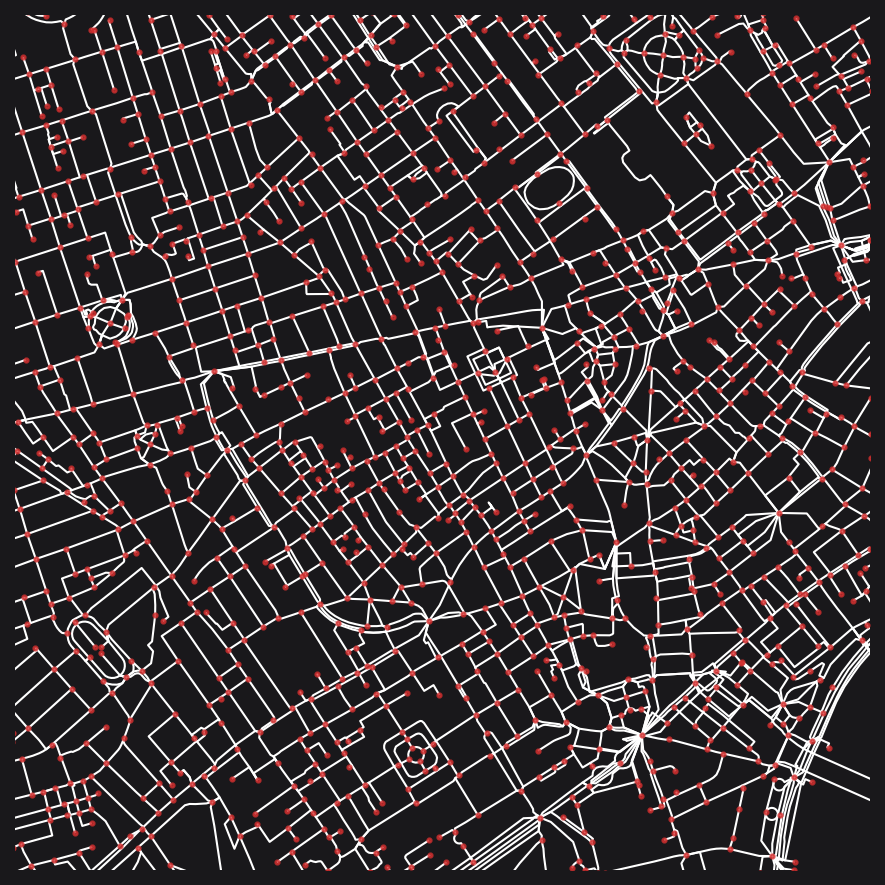

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(multi_di_graph_simpl, tolerance=10, dead_ends=True)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = io.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to immediately convert the `osmnx` graph to `cityseer` before downstream processing. This is preferable because it is then easier for `cityseer` to retain the integrity of the roadway geometries while enforcing node coordinate validation for intersections.


In [4]:
# WORKFLOW 2: Using cityseer to manually clean an OSMnx graph
# ===========================================================
G_raw = io.nx_from_osm_nx(multi_di_graph_raw)

INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 27510/27510 [00:11<00:00, 2387.04it/s]


INFO:cityseer.tools.graphs:Converting networkX graph from WGS to EPSG code 32630.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 14387/14387 [00:00<00:00, 78753.40it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 16418/16418 [00:01<00:00, 12508.38it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 16418/16418 [00:00<00:00, 20305.94it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14387/14387 [00:03<00:00, 3888.81it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4764/4764 [00:00<00:00, 178213.59it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 4243/4243 [00:00<00:00, 29826.56it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/graphs.py:1086: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with 

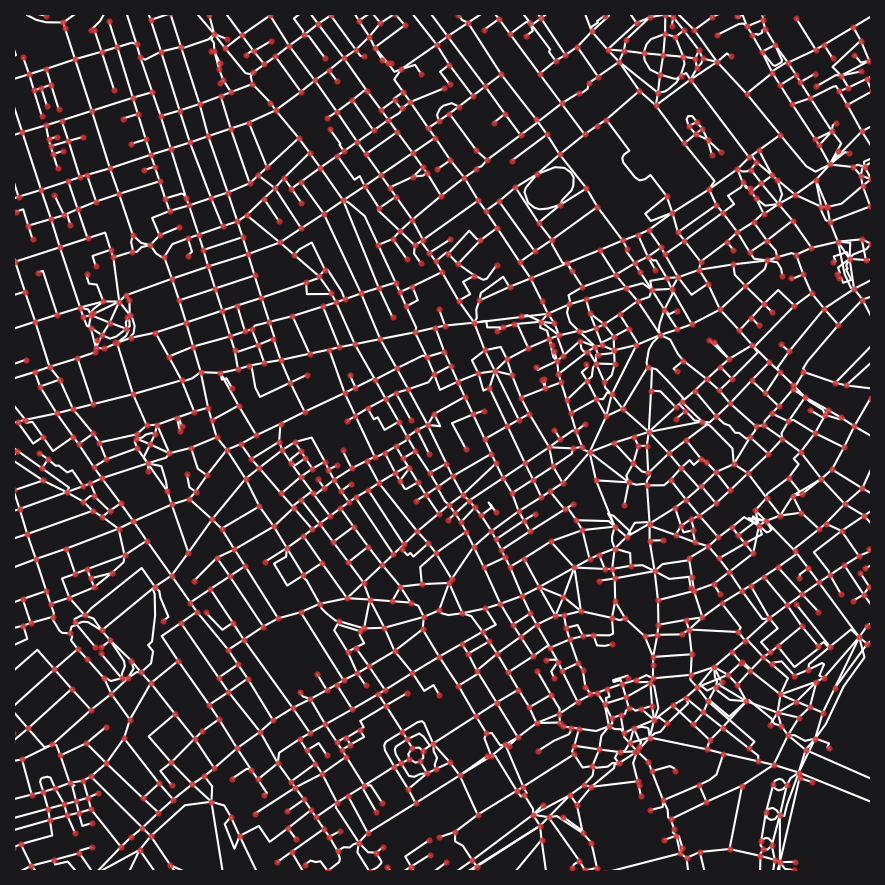

In [5]:
G = graphs.nx_wgs_to_utm(G_raw)
G = graphs.nx_simple_geoms(G)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=15, crawl=True, min_node_group=4, cent_min_degree=4, cent_min_names=4)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(
    G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4, cent_min_names=4
)
G4 = graphs.nx_iron_edges(G3)
simple_plot(G4)

## Workflow 3

Another option is to download the OSM graph from within `cityseer`. The following uses a default OSM query, however, the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) can be used to roll-your-own. See documentation for more information.


INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to EPSG code 32630.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 11631/11631 [00:00<00:00, 143521.88it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 13203/13203 [00:00<00:00, 830071.58it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 13203/13203 [00:00<00:00, 33702.44it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 11631/11631 [00:01<00:00, 6596.13it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 3790/3790 [00:00<00:00, 322638.77it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3357/3357 [00:00<00:00, 41372.43it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 3091/3091 [00:00<00:00, 4967.84it/s]
INFO:cityseer.tools.graphs:Removi

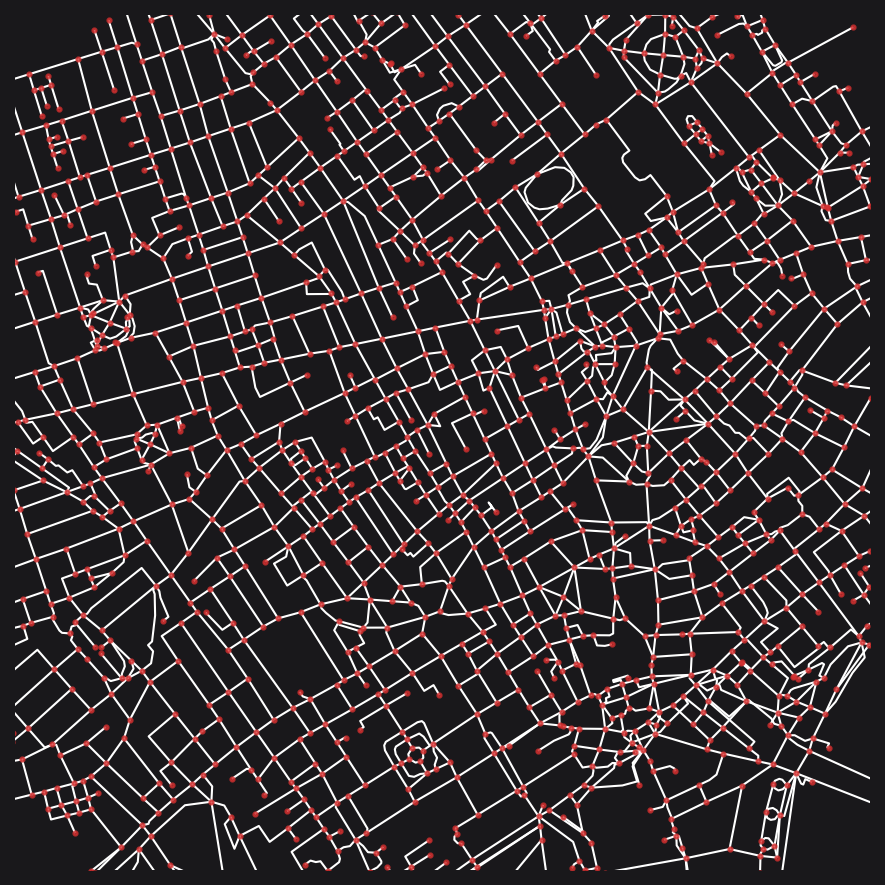

In [6]:
# WORKFLOW 3: Using cityseer to download and automatically simplify the graph
# ===========================================================================
poly_wgs, _poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer_dist)
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True, remove_parallel=True, iron_edges=True)
simple_plot(G_utm)